iQuHack 2026 - BlueQubit 2026 
Problem 7: Rolling Ridge 🏞️
qubits: 46
Points: 70
'This circuit can be decomposed into smaller subcircuits. Analyze qubit interaction graphs and factor the problem into parts before recombining the results.'

In [2]:
import numpy as np
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile

import re
import networkx as nx

path = "C:/Users/elena/OneDrive/IQuhack/P7_rolling_ridge.qasm"

qc = QuantumCircuit.from_qasm_file(path)
qasm_text = open(path).read()
qasm_file = path


we want to divide the qubits into groups that have the least entanglement between them. this is so we can split the processing of the argmax code by the matrix product state into more than one group to calculate them separately. 

we therefore have to identify which qubits are in which group.to do so, we want to draw a graph - where each node is a qubit and an edge is whether a 2qubit gate acts on it. 

here

In [3]:
#these compile functions are building a search tool to find the cz and u3 gates 
#in the qasm program. 
#essentially REGEX patterns for my qasm format in the file
CZ_RE = re.compile(r'^\s*cz\s+q\[(\d+)\],\s*q\[(\d+)\]\s*;\s*$')
U3_RE   = re.compile(r'^\s*u3\(([^)]+)\)\s+q\[(\d+)\]\s*;\s*$')
QREG_RE = re.compile(r'^\s*qreg\s+q\[(\d+)\]\s*;\s*$')

#function that reads the number of qubits from the qasm file
def read_num_qubits(qasm_text: str) -> int:
    """Extract n from 'qreg q[n];'."""
    for line in qasm_text.splitlines():
        m = QREG_RE.match(line)
        if m:
            return int(m.group(1))
    raise ValueError("Couldn't find 'qreg q[...]' line")

#function that builds the interaction graph from the qasm file
def build_interaction_graph_for_this_file(qasm_text: str) -> nx.Graph:
    """
    Nodes: qubit indices.
    Edges: whenever we see 'cz q[i],q[j];'
    """
    n = read_num_qubits(qasm_text)
    G = nx.Graph() #builds empty graph
    G.add_nodes_from(range(n)) #adds all qubits as nodes 

    for line in qasm_text.splitlines():
        m = CZ_RE.match(line) #asks if the line matches the cz gate format. if so, then M obtains value. if not, then m is nothing
        if m:
            i, j = int(m.group(1)), int(m.group(2)) #extracts qubit numbers
            G.add_edge(i, j) #adds edge between qubits i and j
            
    return G

#function that extracts clusters from the interaction graph
def extract_clusters(G: nx.Graph):
    """
    Returns connected components sorted by size descending.
    Each component is a sorted list of qubit indices.
    """
    comps = list(nx.connected_components(G)) #creates a list of sets - each set is a connected component of the graph
    comps = [sorted(list(c)) for c in comps] #converts the above - each set into a numerically ascending sorted list 
    comps.sort(key=len, reverse=True) #sort those clusters/lists by descending size 
    return comps


In [4]:
import matplotlib.pyplot as plt

def draw_graph(G):
    plt.figure(figsize=(10, 10))
    
    # Layout algorithm: spreads nodes nicely
    pos = nx.spring_layout(G, seed=42)
    
    nx.draw(
        G, pos,
        with_labels=True,
        node_size=400,
        font_size=8,
        node_color="lightblue",
        edge_color="gray"
    )
    
    plt.title("Qubit Interaction Graph (edges = CZ gates)")
    plt.show()


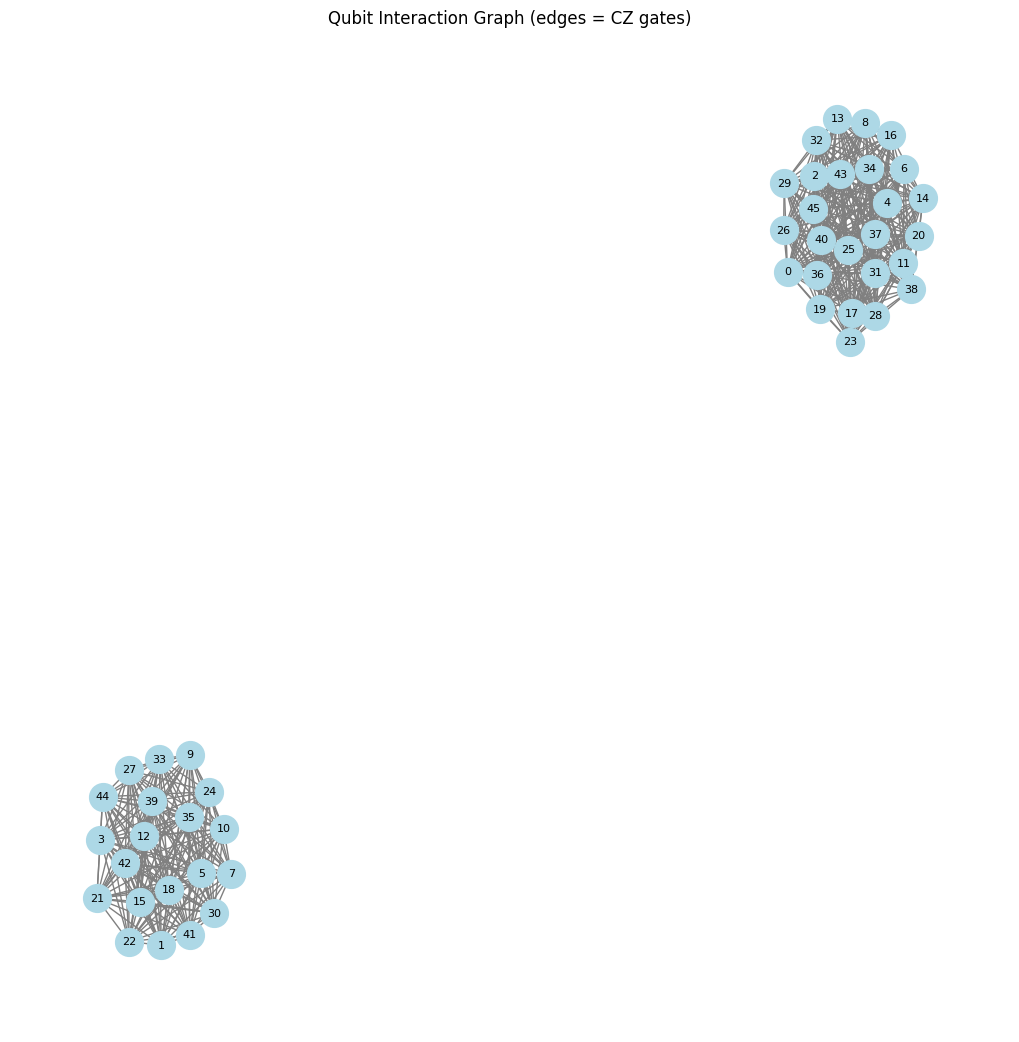

In [5]:
G = build_interaction_graph_for_this_file(qasm_text)
draw_graph(G)


In [6]:
clusters = extract_clusters(G)

print(f"Found {len(clusters)} clusters (connected components).")
for k, comp in enumerate(clusters, start=1):
    print(f"Cluster {k} (size {len(comp)}): {comp}")

compA = clusters[0]
compB = clusters[1]


Found 2 clusters (connected components).
Cluster 1 (size 26): [0, 2, 4, 6, 8, 11, 13, 14, 16, 17, 19, 20, 23, 25, 26, 28, 29, 31, 32, 34, 36, 37, 38, 40, 43, 45]
Cluster 2 (size 20): [1, 3, 5, 7, 9, 10, 12, 15, 18, 21, 22, 24, 27, 30, 33, 35, 39, 41, 42, 44]


In [7]:
def extract_component_qasm(qasm_text: str, qubits: list[int]) -> str:
    """
    Build a new QASM string containing only gates that act entirely inside each cluster.
    Remap original qubit labels -> 0..k-1.
    Supports: u3, cz (matches file).
    """
    qset = set(qubits)
    remap = {q: i for i, q in enumerate(qubits)}
    out_lines = [
        "OPENQASM 2.0;",
        'include "qelib1.inc";',
        f"qreg q[{len(qubits)}];"
    ]

    for line in qasm_text.splitlines():
        line = line.strip()
        if not line:
            continue

        # Skip headers
        if line.startswith("OPENQASM") or line.startswith("include") or line.startswith("qreg"):
            continue

        mu = U3_RE.match(line)
        if mu:
            params = mu.group(1)          # "theta,phi,lambda" as text
            q = int(mu.group(2))
            if q in qset:
                out_lines.append(f"u3({params}) q[{remap[q]}];")
            continue

        mc = CZ_RE.match(line)
        if mc:
            i = int(mc.group(1))
            j = int(mc.group(2))
            if i in qset and j in qset:
                out_lines.append(f"cz q[{remap[i]}],q[{remap[j]}];")
            continue

    return "\n".join(out_lines) + "\n" # this returns a valid qasm string for the cluster

def peak_bitstring_from_qasm_string(qasm_str: str) -> tuple[str, float]:
    """
    Simulate exact statevector and return:
      (peak_bitstring, peak_probability)
    """
    qc = QuantumCircuit.from_qasm_str(qasm_str)
    sv = Statevector.from_instruction(qc)
    probs = np.abs(sv.data) ** 2
    idx = int(np.argmax(probs))
    n = qc.num_qubits
    bitstring = format(idx, f"0{n}b")
    return bitstring, float(probs[idx]) #this returns the peak string with the length of 
#the cluster, and the probability of measuring that string

def recombine_peaks(n_total: int, clusters: list[list[int]], peaks: list[str]) -> str:
    #n_total is number of qubits in og circuit, clusters = [compA, compB], peaks = [peakA, peakB]
    """
    Put each cluster's peak bits back into the original qubit ordering.
    Returns full-length bitstring indexed by q[0]..q[n_total-1].
    """
    bits = ["0"] * n_total
    for qubits, peak in zip(clusters, peaks): #pairs each cluster with its peak string
        if len(peak) != len(qubits):
            raise ValueError("Peak length doesn't match cluster size.")
        
        # reverse because counts are returned as c[k-1]...c[0]
        #NEW ADDITION!! 
        peak = peak[::-1]

        for local_i, orig_q in enumerate(qubits): #local index with the cluster and the corresponding original qubit label
            bits[orig_q] = peak[local_i]
        #essentially places each peak bit into its original qubit position    
    return "".join(bits) #turns the list of bits into a string 



In [ ]:
def peak_bitstring_by_sampling(qasm_str: str, shots=200000):
    qc = QuantumCircuit.from_qasm_str(qasm_str)

    # If there are no measurements in the QASM, add them
    if qc.num_clbits == 0:
        qc.measure_all()

    sim = AerSimulator()  # qasm sampling backend
    tqc = transpile(qc, sim, optimization_level=0) # transpiling means adapting the circuit to the backend
    result = sim.run(tqc, shots=shots).result()
    counts = result.get_counts()

    peak = max(counts, key=counts.get)
    peak_prob_est = counts[peak] / shots
    return peak, peak_prob_est

In [ ]:
# Simulate each cluster
peaks = []
peak_probs = []
n_total = read_num_qubits(qasm_text)
for k, qubits in enumerate(clusters, start=1):
        sub_qasm = extract_component_qasm(qasm_text, qubits)
        #peak_str, peak_p = peak_bitstring_from_qasm_string(sub_qasm)
        peak_str, peak_p = peak_bitstring_by_sampling(sub_qasm, shots=300000)
        peaks.append(peak_str)
        peak_probs.append(peak_p)

        print(f"\nCluster {k} result:")
        print(f"  size: {len(qubits)}")
        print(f"  peak bitstring (local order 0..{len(qubits)-1}): {peak_str}")
        print(f"  peak probability: {peak_p:.6g}")

# Recombine into full 46-bit answer
full_peak = recombine_peaks(n_total, clusters, peaks)

full_prob = 1.0 
for p in peak_probs: 
    full_prob *= p


print("\nRecombined full peak (q[0]..q[n-1]):")
print(full_peak)
print("\nEstimated full peak probability:")
print(full_prob)




Cluster 1 result:
  size: 26
  peak bitstring (local order 0..25): 01001111111011000001001000
  peak probability: 0.598763

Cluster 2 result:
  size: 20
  peak bitstring (local order 0..19): 10011110110100111100
  peak probability: 0.599347

Recombined full peak (q[0]..q[n-1]):
0000011101100100001000111100111111111101000110

Estimated full peak probability:
0.35886680795555553


: 